# 1 Introduction

This notebook was created for the purpose:

* Exploring the data
* Filling missing values
* Creating a blind set
* Figuring out how to create a heatmap for the demand.

## 1.1 Google Colab Mount

First I have to mount my Google Drive so that I can load the CSV file for the dataset.

In [0]:
from google.colab import drive
drive.mount('/content/Gdrive')
% cd '/content/Gdrive/My Drive/Colab Notebooks/Traffic_Forecasting'
! ls

## 1.2 Dependecies Load

Below are the known dependencies I will be using for the notebook. One particular dependency that has to be modified when working with Google Colab is scipy. The scipy version on the default Colab session is version 1.3. This version is having issues on the statsmodel so we have to manually downgrade the version. This is done in this section because this would require a restart of the runtime for the lower version to be loaded.

In [0]:
!pip install scipy==1.2

In [0]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation,PillowWriter
import seaborn as sns
import numpy as np
import pickle
import math
import time
from fbprophet import Prophet
from math import log10
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook

from IPython.display import HTML, Image

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,10
rcParams['figure.dpi'] = 75
rcParams['agg.path.chunksize'] = 10000
rcParams['animation.html'] = 'html5'
plt.rcParams['axes.facecolor'] = 'white'

pd.set_option('display.max_row', 1000)
pd.set_option('display.max_column', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x) # Just to make some floats easier to look at. Will not change dtype.

## 1.3 Dataset Load

Using Pandas `read_csv` I can load up the dataset.

> **NOTE**: If this is going to be tested, I suggest that the holdout data be loaded in this portion as well and concatenated to the training dataset so that the preprocessing can be applied on one go. This should help avoid potential issues when preprocessing them separately and concatenating after.

In [0]:
data = pd.read_csv('./Traffic Management/training.csv')
data.info()

## 1.4 Miscellaneous Functions

In [0]:
# Misc Functions
# Basic RMS function.

def RMS(pred_val, true_val):
    return math.sqrt(((true_val-pred_val)**2).mean())

def sklearn_RMS(pred_val, true_val):
    from sklearn.metrics import mean_squared_error
    return (mean_squared_error(true_val, pred_val))**0.5

# 2 Dataset Features

In [0]:
data.head()

## 2.1 Adding Features

### Temporal

**get_time** - Splits the `timestamp` to the `hour` and `minute` values. `timestamp`will be dropped and the `minute` and `hour` values will be added to the dataframe.

**data_add_year** - Adds an arbitrary year column. In this case I chose to use `2019`. This is an arbitrary value, we should be able to change this if we have the actual year but for the purposes of getting a valid `datetime` index I am adding `2019`. This would simply add a column to the dataframe with the selected year value.

**add_mnth** - Another arbitrary value selection. Created for the purposes of  having a `datetime` index later on. The months chosen are *March* and *April*.  This should be able to handle data until `May`.<br>
> **NOTE**:If new data would be added to the dataframe the `day` should be continued from day 61. For example, if the model would be later asked to predict D+10, then that would be day 71. Otherwise the data would be resolved to Day 10 which would lead to duplicate demand which could potentially break the model.

**add_mnth_day** - Adding day of the month value to the dataframe.  This is hardcoded and will not be able to handle continuity on February where the days are 28 or 29. This assumes that all months are alternating 30 and 31 days.

**check_day** - Adding the day of the week based on the day value. Do note that this is not an accurate representative of the acutal day of the week, 1 should not be assumed to mean Monday, 2 is not assumed Tuesday.

**add_stamp** - Adds a pandas DateTimeIndex values to the list to correspond to the date and time of the data.

### Spatial

**lat_long_lookup** - Looksup the latitude and longitude of the data point given the geohash value. Note that `lat_lookup` and `long_lookup` were created based on Python Geohash module, `decode_exactly` function. Since the challenge rule states that the holdoff data would be within the same set as the test data I decided to create a lookup table for faster retrieval of latitude and longitude values.

**geohash_encode_lookup** - Adds a unique integer geohash identifier for every geohash6 value available on the data. Uses `LabelEncoder` from sklearn.

In [0]:
def get_time(data):
    hour = []
    minute = []
    for item in data['timestamp']:
        hour.append(item.rsplit(sep=':')[0])
        minute.append(item.rsplit(sep=':')[1])
    data['hour'] = hour
    data['minute'] = minute
    data.hour = pd.to_numeric(data.hour, errors = 'coerce').astype(np.int16)
    data.minute = pd.to_numeric(data.minute, errors = 'coerce').astype(np.int16)
#     data = data.drop('timestamp', axis = 1)
    return data

def data_add_year(data):
    data['year'] = 2019 # Arbitrary year
    return data

def add_mnth(data):
    '''
    Adding arbitrary date, just to make it easier for datetime conversion and arrange the data
    '''
    month=[]
    for item in data['day']:
        if item <= 31:
            month.append(3) # March 2019
        elif item >31 & item <=61:
            month.append(4) # April 2019
        else:
            month.append(5) # May 2019 (Arbitrary). This would fail the `days` value gets past the days for May 2019.
    data['month'] = month
    return data

def add_mnth_day(data):
    mnth_day = []
    for item in data['day']:
        if item > 61:
            day = item%61
        else:
            day=item
        mnth_day.append((day)%31)
    data['mnth_day'] = mnth_day
    data.loc[data['mnth_day']==0, 'mnth_day']=31 # Fixing days that will be 0 instead of 31
    return data

def check_day(data):
    '''
    Checking the day of the week based on the value of day_index
    Do note that this is also arbitrary since I do not know when exactly the timeframe started.
    Adding this since there must be some factor of the time of date and I would like for my regressor to figure it out if possible.
    '''
    lookup = {1:1,2:2,3:3,4:4,5:5,6:6,0:7}
    dow = []
    for item in data['day']:
        dow.append(lookup.get(item%7))
    data['dow'] = dow
    return data

def add_stamp(data):
    data['date'] = pd.to_datetime({'day':data.mnth_day,
                               'month':data.month,
                               'year':data.year,
                               'hour':data.hour,
                               'minute':data.minute                              
                              })
    data['date']=pd.to_datetime(data.date,format='%Y-%m-%d-%H:%M')
    return data

def lat_long_lookup(data):
    '''
    Decoding the latitude and longitude the individual Geohash codes.
    Via Lookup table
    '''
    lat_lookup = pickle.load(open('lat_lookup.pickle','rb'))
    long_lookup = pickle.load(open('long_lookup.pickle','rb'))
    lat = []
    long = []
    for item in data['geohash6']:
        lat.append(lat_lookup.get(item))
        long.append(long_lookup.get(item))
    data['lat_lookup'] = lat
    data['long_lookup'] = long
    return data

def geohash_encode_lookup(data):
    from sklearn.preprocessing import LabelEncoder
    geo_encoder = LabelEncoder()
    
    data['geo_encoded']=geo_encoder.fit_transform(data['geohash6'])
    return data


## 2.2 Preprocessing pipeline

The `data_process` function below acts as the processing pipeline for the dataframe. We can choose to add or remove preprocessing steps by commenting out or appending the included preprocessing functions.<br><br>
> **Note**: It is assumed that the dataframe up until the final date point prior to the prediction has been included in the `data`. This helps ensure that there would be minimal bugs in the preprocessing. I believe this would be safer than adding features to the original data and the holdoff data separately and concatenating them afterwards.

In [0]:
def data_process(data):
    data = get_time(data)
    data = data_add_year(data)
    data = add_mnth(data)
    data = add_mnth_day(data)
    data = check_day(data)
    data = add_stamp(data)
    data = lat_long_lookup(data)
    data = geohash_encode_lookup(data)
    data.sort_values(by=['date'], inplace=True)
    data.reset_index(inplace=True)
    data.drop('index',inplace=True, axis=1)
    return data

### 2.2.1 Applying Features

Running the code below would add all the feature columns to the dataset `data`. On the entire *Demand dataset* given during the challenge it takes about 25 seconds to complete.

In [0]:
%%time
data = data_process(data)

In [0]:
data.tail()

# 3 Temporal Analysis

I want to check out the effect of time on the actual data, basically a temporal analysis exploration. To save time I am going to be selecting a single geohash6 location. The assumption I am making is that this geohash6 location will exhibit a representative trend and seasonality for the entire dataset. I am not aiming for accuracy in this section, just an understanding of the data.

## 3.1 FB Prophet

I am going to be using Facebook's prophet tool to make the analysis pipeline simpler. I have no prior use of Prophet prior to this one but their [Documentation and quick start guide](https://facebook.github.io/prophet/docs/quick_start.html) was quite helpfull in getting my desired results.

### 3.1.1 Pulling a single Geohash location data

Below I am pulling a single geohash location data from the dataset. This was randomly chosen, as stated before, I just want to get a *very general* idea of the trend and seasonality of the data.<br><br>To make use of Prophet we only need to have the demand and the datestamp so I have also dropped the other columns of the dataset.

In [0]:
prophet= data.loc[data['geohash6']=='qp09sw']
prophet.drop(['geohash6','day','timestamp','lat_lookup','long_lookup','hour','minute','year','month','mnth_day','dow','geo_encoded'],inplace=True,axis = 1)

In [0]:
prophet.tail()

### 3.1.2 Formatting Data

As mentioned in the documentation, Prophet is quite particular with how the input data is formatted. It requires the columns to be in proper labels. The date column needs to be labeled `ds` and the demand has to be labeled `y`. Below I am simply renaming the column names and rearranging them. Prophet doesn't mind the index, at least not that I am aware of, so it should be good to keep as is.

In [0]:
prophet = prophet.rename(columns={'demand':'y','date':'ds'})
prophet = prophet[['ds','y']]
prophet.tail()

### 3.1.3 Train and Test split

For this I am going to split the data by date. The training set would be up until `2019-04-15 00:00` and the remaining dates would be for testing(predictions). It should translate to a rough 75-25 split.

In [0]:
train_set = prophet.loc[prophet['ds']<'2019-04-15-00:00']
t_set = prophet.loc[prophet['ds']>'2019-04-15-00:00']
print('Train Set = {}\nTest Set = {}'.format(train_set.shape, t_set.shape))

### 3.1.4 Vanilla Prophet

Since the purpose of this section is to get the seasonality and trend from the dataset I will not be playing around with the model hyperparameters. I will simply load up the vanilla Prophet model and fit the train set. This takes roughly 2 seconds to fit so its quite fast.

In [0]:
%%time
model = Prophet()
model.fit(train_set)

#### 3.1.4.1 Making Predictions

To get an idea of how good(or bad) Prophet is, I also asked it to come up with predictions for the test set range. Prophet is smart enough to infer the frequency of the predictions which is quite amazing. The full forecasting call took around 5.25 seconds.

In [0]:
future = t_set

In [0]:
%%time
forecast = model.predict(future)

#### 3.1.4.2 RMS score

To prepare for an RMS calculation for the forecast I added back the true values of `y` to the forecast data. The RMS score was 0.06 which is quite impressive considering the ammount of effort needed to prepare the data, fit the model and come up with the predictions.

In [0]:
forecast['y_true'] = future['y'].values

In [0]:
rms_score = RMS(forecast['y_true'],forecast['yhat'])
print('RMS Score for Prophet: {}'.format(rms_score))

### 3.1.5 Results

I have created a plot of the results of the model after fitting. The the red vertical line is the demarcation between the train and test set. The blue scatter plot to the left are the actual values of train. To the right of the red line are the results of the predictions which I think are relevant. First is the **orange scatterplot** which corresponds to the **true value** for that date. The **green scatter** plot corresponds to the **predicted value** for that time. The **blue** and **orange** lineplot are the **Upper and Lower confidence bound** for the predictions.<br><br>

In [0]:
fig, ax = plt.subplots(figsize=(15,5), dpi=75)
# Saving data/notebook size. For better plot, Comment out the line above and uncomment the one below.
# fig, ax = plt.subplots(figsize=(100,10), dpi=100)
# Adding date and demand
# Train Set
ax = sns.scatterplot(x=train_set['ds'],y=train_set['y'],label = 'Train', s=8)
# ax = sns.lineplot(x=train_set['ds'], y=train_set['y'], label='Train', markersize=8) # uncomment this line if you prefer the lineplot, Make sure to comment out scatter.
# Forecast Set
ax = sns.scatterplot(x=forecast['ds'], y=forecast['yhat'], label='Predictions', s=8) # Predictions
ax = sns.lineplot(x=forecast['ds'], y=forecast['yhat_upper'], label='upperbound', markersize=8) # Upper Confidence level
ax = sns.lineplot(x=forecast['ds'], y=forecast['yhat_lower'], label='lowerbound', markersize=8) # Lower Confidence Level
ax = sns.scatterplot(x=forecast['ds'], y=forecast['y_true'], label='Actual', s=8)
# ax = sns.lineplot(x=forecast['ds'], y=forecast['y_true'], label='Actual', markersize=8) # uncomment this line if you prefer the lineplot, Make sure to comment out scatter.

# Test Train separator
plt.axvline(linestyle='dotted', color='r',x=pd.to_datetime('2019-04-15 00:00:00'))

# Date Bounds: To focus more on the test train transition. Feel free to set it to 2019-02-28 and 2019-05-01 for the full dataset run.
ax.set_xlim([pd.to_datetime('2019-04-10 23:50:00'), pd.to_datetime('2019-04-20 00:10:00')])
ax.set_title('Vanilla Prophet forecast for qp09sw')
# Rotate the dates
for item in ax.get_xticklabels():
    item.set_rotation(45)

## 3.2 Statsmodel (NOTE: Run the Autoencoder chapter first)

Now that we have encoded the data we can check and confirm the findings we had from Prophet. Below is the Seasonal Decomposition plot for the encoded data. I have set the frequency to 96 on the first decomposition.


In [0]:
encoded_data_2 = pd.read_pickle("Encoded_data.pkl")

Loading up the pickled data from the encoder.

<Figure size 800x560 with 0 Axes>

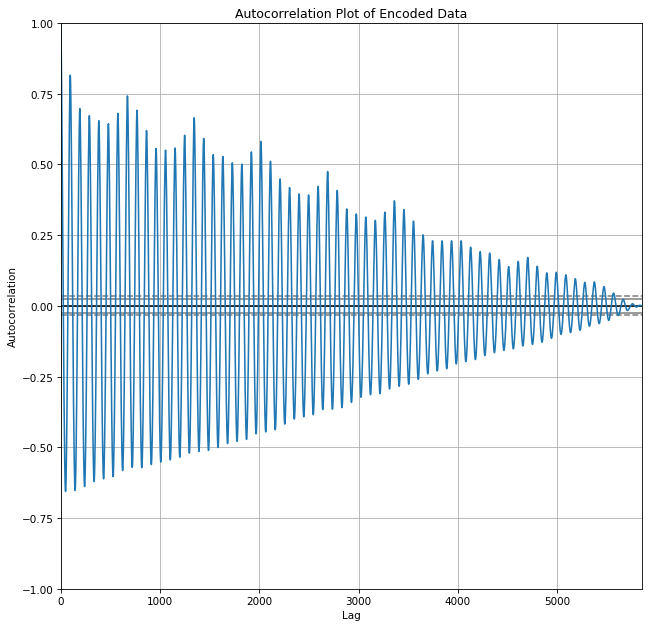

<Figure size 800x560 with 0 Axes>

In [0]:
from pandas.plotting import autocorrelation_plot

series = encoded_data_2['encoded'].values
autocorrelation_plot(series)
plt.title('Autocorrelation Plot of Encoded Data')
plt.figure(figsize=(10, 7), dpi=80)
##plt.show() 

Seasonal Decomposition Hourly time-Frame


<Figure size 750x750 with 0 Axes>

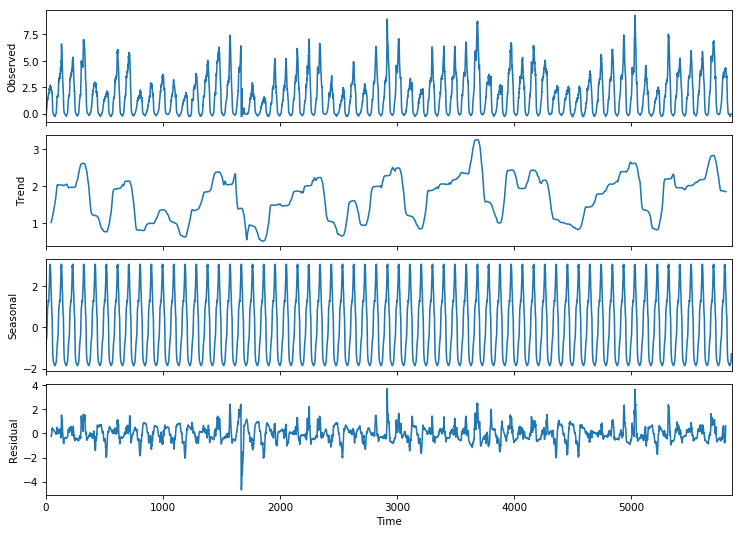

In [0]:
# Source: https://www.kaggle.com/aless80/sarimax-on-mean-visits
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series, freq=96)  # If I understand it correctly, the frequency is daily. 4 (15-minute buckets) x 24 hours = 96
fig = plt.figure()  
fig = decomposition.plot()
fig.set_size_inches(10, 7)
print('Seasonal Decomposition Hourly time-Frame')

### Seasonal Decomposition Findings

We see trend and seasonality on the daily which confirms what we saw on Prophet for a single location data.

If I understand it correctly the trend in this timeframe would refer to the hourly while seasonality would be for the 15-minute buckets. For the decomposition above, the **observed** values are. We see the troughs of the evenings data and we also see the form on which the demand starts to crest from late evening to dawn until lunch of the next day.

The seasonality in terms of 15-minute buckets is quite expected. We have to note that there is quite an increase in terms of minute buckets but its fairly equal.

We can also now see the residuals for the data which interestingly contributes a good ammount of weight on the fluctuations. Looking at it we could detect possible dates where there are spikes. For example there is an instance where the residual contributed a -0.5 drop only on one instance. It looks like there are missing dates in our data. Another interesting finding would be residuals that are above the patterns like huge spikes. These could be due to holidays or special events during that time. Maybe I could use an anomally detection for the residual sequence on future projects. Knowing where these anomallies are could help us scrape other forms of data like dates of holidays or possibly tweets where we could get additional features to help detect future anomallies. Knowing when an anomally might happen could help us provide better services. For example if we came up with a model that flags trending tweets and relates that to higher demand spike then we can direct resources to meet those demands.

Seasonal Decomposition Weekly time-Frame


<Figure size 750x750 with 0 Axes>

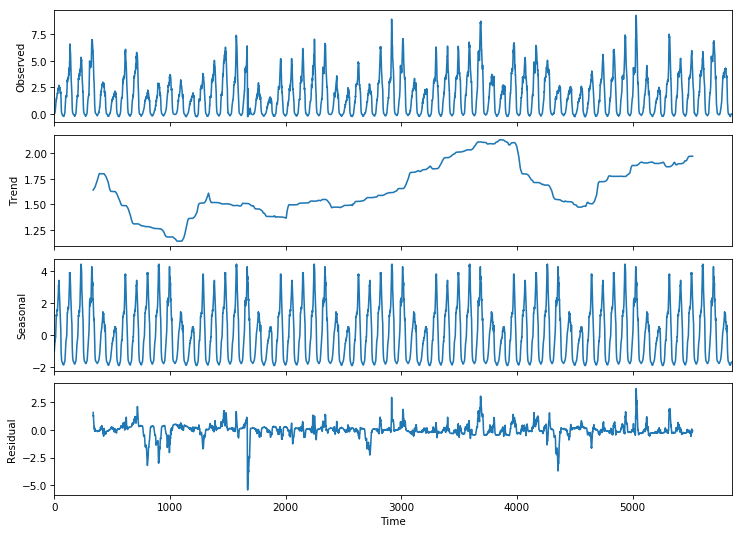

In [0]:
decomposition = seasonal_decompose(series, freq=(96*7))  # If I understand it correctly, the frequency is daily. 4 (15-minute buckets) x 24 hours = 96 * 7 days per week.
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(10, 7)
print('Seasonal Decomposition Weekly time-Frame')

ACF and PACF of the Encoded Data


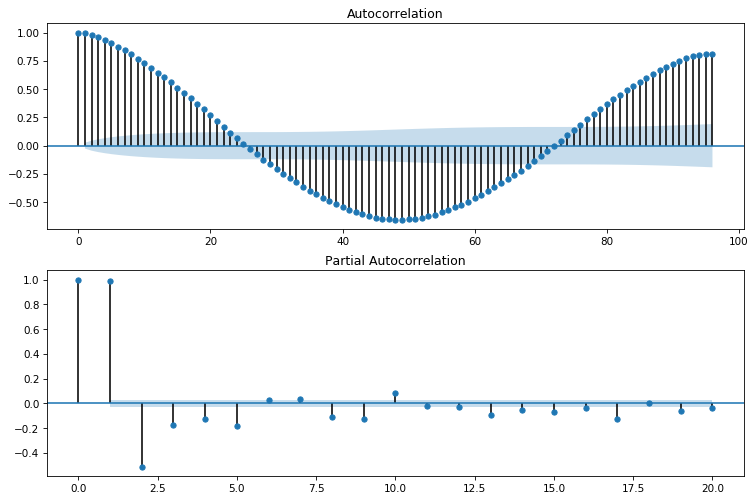

In [0]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series, lags=96, alpha=.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series, lags=20, alpha=.05, ax=ax2)
print("ACF and PACF of the Encoded Data")

### 3.2.1 Trends and Seasonalities

One additional feature of Prophet is the ability to plot the trend and sesasonalities that it has found on the data. In terms of **Trend** there is a slight upward trend. This should mean that in general our demand is increasing which is always a good sign. The implaction could be that more people are using the service. Either way, it should tell us that we would probably need to prepare additional resources to cope with the trend.<br><br>
In terms of seasonality, the vanilla Prophet model was able to come up with 2 seasons, **Weekly** and **Daily**. In terms of weekly we see the seasonality of the data based on the days of the week. Demand tends to reduce midweek Wednesday and start to pick up again on through the weekend and then repeats the cycle. I have checked with other locations before and I found that the seasonality structure for the weekly tends to be the same, crests on the weekends and troughs midweek. What is interesting is that some locations tend to have different days of through and crest, generally +/- 1 day. It should be noted that the date selected for the data was arbitrary during the feautre selection so I am focusing more on the structure of the seasonality rather than the actual day of the week. What we can come up with based on this inforation is the scheduling of our drivers/service providers.<br>

If the seasonality structure holds then we can schedule some off days for our drivers. This way we provide a possible solution to the problem statement of the challenge which is to help reduce the traffic congestion. In this case we could help relieve congestion by:
allowing only enough cars to  match the demand based on the day of the week.

Another seasonality that is provided by Prophet is the seasonality on the **Daily** level. We see that the demand tends to peak on the morning period and taper off from the afternoon to until late evening until picking up again on the late evenings towards dawn of the next day and this repeats. This structure tends to hold true for all the locations. We have reduced demand from the afternoons to the evening and most of our demand are from late evenings to around lunch time. One theory I have is that this is related to the availability of other means of transport on certain times of day. I think the demand starting to crest again around late evenings is that there would be limited public transportation available. Late evenings until dawn are mostly underserved by public transport and that is where our services are needed. Our users also tend to use our services on early morning commute. Our demand would usually die down in the afternoon until the evening where, building up on the theory of availability of other means of transport, other means of transport are available.



In [0]:
figure_2 = model.plot_components(forecast)

### 3.2.2 Key Points

Key points from the trends and seasonality.

>* Being able to see the trend helps us plan our resource acquisition better by knowing the rate of growth we can expect.<br>
>* Supposing that the seasonality structure holds, we get to help reduce the number of cars in the road by limiting the supply of drivers to match the projected demand.<br>
>* By knowing the demand seasonality, even on the weekly and daily, we provide additional time for our drivers to spend with their families by keeping them informed of the demand and supply situation on specific days of week and hours of day.<br>
>* By addressing the dates and hours of low demand we help drivers that are active find fares quicker by ensuring that there is no oversupply.<br>
>* Even with measures of reducing cars on the road, we should still be able to maintain our quality of service by knowing when and how much to increase resources.<br>

# 4 Spatial Analysis - Heatmap Generation

In this section I was exploring the data. I wanted to combine both spatial (location) and temporal (time) factors to have a better understanding of the dataset. I chose to create an animated Heatmap in the form of a hexbin. Using MatplotLib `animation` I was able to get videos of the hexbins showing areas of activity for the given dataset grid.<br><br>
There was a lot of help needed to make this section possible and I would like to link point to [this post from louistiao](http://louistiao.me/posts/notebooks/save-matplotlib-animations-as-gifs/) which I refered to when debugging the animation. Another note is that this module would require `IPython.display` and `HTML` animations in order to view the created GIF. This notebook was created on Google Colab so there would be a lot of dependencies pre-installed by default. If in any case you would encounter an issue with the dependencies version I have used `pip freeze` to get the list of dependencies that were installed and their version to help debug issues.

### 4.1 Dependencies load

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML, Image
rc('animation', html='html5')

### 4.2 Date Range

Creating a list of dates that the `update` function would use to know which data point is going to be used. I have set the frequency of the generated date_range to Hourly (**1H**). It would be possible to use 15-minute intervals or daily intervals by changing the `freq` value. For 15-minute intervals change it to `15T` and for daily I believe its `1D`. Kindly refer to the Pandas datetime accepted frequency identifiers.<br>
> **NOTE**: Make sure that the date range and frequency matches the available date in the dataset. For example, the model will not create a continous heatmap on freq = `1T` or 1 minute intervals. Tested invtervals that worked were `1H` and `15T`. I cannot guarantee that the code will work on all possible frequency combinations.

In [0]:
# full_date = pd.date_range(start='2019-03-21 00:00:00', end= '2019-03-28 23:00:00', freq='1H')
full_date = pd.date_range(start=data['date'].min(), end= data['date'].max(), freq='15T')

### 4.3 Update Function

As a requirement of the `FuncAnimation` of matplotlib, we need to define a function of what will be created for every interval. What is expected is for us to provide the output image or graph per frame. So in my case I have to create a hexbin for every iteration. I have already create the list `full_date` to define the list of datetime that I would want to create a hexbin of. For every iteration of `update` it should create the heatmap of the demand for a datetime.<br><br>
If you would like to play around with the animation, I suggest you only change the following variables:
<br>
* **`figsize`** - This would be the output size of the plot in inches I believe. We can change this to change the size of the final plot image.
* **`dpi`** - This sets the dots per inch value of the plot, the higher the value the more "detailed" the final plot would be although a very high dpi value would lead to a huge file size.
* **`gridsize`** -  This defines the binning of the data. The higher the gridsize the finer the detail but the more scattered the data points are going to be.
* **`cmap`** - Defines the color map to be used in the plotting. I suggest you take a look at this [tutorial from Matplotlib](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) on the available cmap values. 
* **`extent`** - Defines the axes boundaries of the plot. Do note that because of binning/gridsize, there might be issues on the display if we use the actual minimum and maximum values for latitude and longitude. I suggest you only increase the size of the extent and not make it any smaller to ensure that the plot would still come out. A plot that is not within the extent would obviously not get plotted.
* **`set_facecolor`** - If using the cmap `afmhot`, I suggest a black `colored`face for the plot. A good guideline would be to match the lower color range of the cmap and not choose a value close to the high color range of the cmap to avoid perception issues. Using a distinct facecolor will show us which locations do not have any data on them at all. For example, try setting it to `cyan`, this should show us that the lower and rightmost grids do not have any data.

*Additional note*, we can actually comment out the `print` function right before the `return`. This would mute the progress reporting of the animation. I only added it to check the progress of the animation on long sequences.

In [0]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(10,10),dpi=80)
# plt.rcParams['axes.facecolor'] = 'black'


# animation function. This is called sequentially
def update(i):
    import time
    start = time.time()
    date = full_date[i]
    long_ = []
    lat_ = []
    demand_ = []
    
    for row in data.loc[data['date']==date].itertuples():
        long_.append(row.long_lookup)
        lat_.append(row.lat_lookup)
        demand_.append(row.demand)

    # Create Dataframe
    
    holder = pd.DataFrame({'long':long_,'lat':lat_,'demand':demand_})
    
    # Plot the data
    
    hexlayer = ax.hexbin(x=holder['long'],y=holder['lat'],C=holder['demand'], gridsize=30, cmap='afmhot', extent=[90.6,91.0,-5.5,-5.25])
    
    ax.set_title(date)
    ax.set_facecolor('black')
#     print('sample: {} of {} ---- {}'.format(i,len(full_date),time.time()-start))
    return hexlayer,

### 4.4 Creating the Animation

Below is the definition of the animation function we created. Some values we can edit are:<br><br>
* **`frame`** - This is the iterator for the update function. Using `range` allows us to specify the start and end point of the plot as well as the interval. We can use an `integer` value for this. When we use an integer it uses that to determine the stop point of the iteration, the default start point when an `integer` is passed is 0 and a step of 1.
* **`interval`** - This defines the interval between frames for the output animation in milliseconds. The default is 200 although we can edit it to speed up or slow down the final animation. Do note that speeding or slowing down the interval does not necessarily mean a decrease in the final output size. This is more of a function of DPI than interval length.


The output video animation should display and automatically play and loop after the animation has been completed.. If the print function was not muted on the `update` function, you might have to scroll to the bottom part of the output cell.

**NOTE**: I have commented the animation functions to save some space on the notebook. Feel free to uncomment the animation codes below.

In [0]:
# anim = animation.FuncAnimation(fig, update,
#                                frames=range(300,350, 1), interval=200)

# anim

### 4.5 Saving Animation

Below is a code block which should allow us to save the animation as a gif although I would recommend just right-clicking on the output video and save that instead. Do note that running the code block below would essentially run the animation function again.

In [0]:
anim.save('heatmap-animation-WK1.gif', writer=PillowWriter(fps=30))

## 4.6 Findings


### 4.6.1 Unserved Regions

Below is a sample single shot heatmap. I want to check if there are locations which do not have any entries. To better show this, I used a face color of blue (which seems right considering the location was in the middle of the ocean *jk*). If we use check the number of unique latitude and longitude points there should be 1656 points on our grid (46 unique latitudes by 36 unique longitudes). Yet, the total unique geohash6 values only account to 1329 locations. 327 points do not have any data. This could be due to the fact that there was simply no demand on that location or it is physically impossible to get a demand on that location. For example it could be an actual lake, or mountain or a public space like a park.

In [0]:
fig, ax = plt.subplots(figsize=(10,10),dpi=80)

i = 270
date = full_date[i]
long_ = []
lat_ = []
demand_ = []

for row in data.loc[data['date']==date].itertuples():
    long_.append(row.long_lookup)
    lat_.append(row.lat_lookup)
    demand_.append(row.demand)
# Create Dataframe

holder = pd.DataFrame({'long':long_,'lat':lat_,'demand':demand_})

# Plot the data

hexlayer = ax.hexbin(x=holder['long'],y=holder['lat'],C=holder['demand'], gridsize=30, cmap='afmhot', extent=[90.6,91.0,-5.5,-5.25])

ax.set_title(date)
ax.set_facecolor('blue')

### 4.6.2 High Demand Region

Another observation we can get through the heatmap are the locations with their demand. In the sample graph below I have a heatmap of the demand for a certain time. Observing the heatmap animation, we can actually get an idea of which locations tend to have high demand. From what I observed there are two major areas with consistently high demand. First is the area bounded by (90.80, 90.85, -5.38, -5.33), near the center of the plot. Another high demand area would be (90.65, 90.70, -5.33, -5.30), on the middle left area of the plot. I also noticed some consistent regular demand on some outlying region roughly on the upper right quadrant and the area on the lower left quadrant. Given the size of the actual grid box, I would assume that the major demand areas are cities with suburban areas and the regular demand areas on the upper left and lower right are smaller municipalities  or something of that context.

In [0]:
fig, ax = plt.subplots(figsize=(10,10),dpi=80)

i = (96+7)
date = full_date[i]
long_ = []
lat_ = []
demand_ = []

for row in data.loc[data['date']==date].itertuples():
    long_.append(row.long_lookup)
    lat_.append(row.lat_lookup)
    demand_.append(row.demand)
# Create Dataframe

holder = pd.DataFrame({'long':long_,'lat':lat_,'demand':demand_})

# Plot the data

hexlayer = ax.hexbin(x=holder['long'],y=holder['lat'],C=holder['demand'], gridsize=30, cmap='afmhot', extent=[90.6,91.0,-5.5,-5.25])

ax.set_title(date)
ax.set_facecolor('black')


### 4.6.3 Adding Where to the When

Earlier we had an analysis of the trends and seasonality of the data. We have an idea of **When** our demand is going to go up or down. Now, we add another layer to that by having an idea of **Where**. Being able to plot the demand spatiotemporaly alows us to point out the demand per area we serve for a given date. This allows us to know where and when to allocate services for better effeciency.

>* We can now help ensure that users get served in a timely manner by allowing us to direct drivers to areas of demand.
>* Our drivers can now find fares quickly by being able to know which areas will have a high demand.
>* By pointing the drivers away from low demand areas we do our part of not adding to the volumne of cars on the road by reducing loitering times. Although we have to address the possible consequence of pointing majority of our resources to a specific area. Maybe a staging area could be an option, like we designate areas where we pickup users away from major thoroughfares so that we at least decongest it. It could also be possible to maybe team up with parking lots to allow our drivers to *shelter* and act as a staging point so that we are prepositioned to meet demand without taking up space in the roads.
>* We could coordinate better with other agencies to provide inputs on possible locations that might be underserved by public transport so that fewer vehicles are needed to cope with demmand. For example, partnering with buses to *shuttle* our riders to areas outlying the high demand area but still on the way of the commute. This way we can help alleviate the volume of traffic generated in the high demand areas. We help our drivers save time and gas having to go through the traffic. We help our co-service providers as well by sharing resources. 


*This is under the assumption that the high demand areas are CBDs where major mass of commuters are expected to be generated at specific times. Since this only shows demand data and not source and destination data everything has to be taken with a grain of salt. One possible case where the suggestions above would not be applicable is when the destination of the riders are inside the areas of high demand only, like a short trip. Having the actual movement of the rides from start to end points would be a good additional feature. This way we can plan trips better.*

**NOTE**: I have commented the animation functions to save some space on the notebook. Feel free to uncomment the animation codes below.

In [0]:
# sample_anim = animation.FuncAnimation(fig, update,
#                                frames=range(300,350, 1), interval=200)
# sample_anim